<a href="https://colab.research.google.com/github/ali-workshop/Chest_dignosis_using_deep_learning_transfer-learning-high-accuracy-94-/blob/main/Chest_dignosis_using_deep_learning_Networks_final_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import the necessary libraries

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 ,  densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
import cv2 as cv

#loading the dataset

In [ ]:
train_path = "/content/chest-ctscan-images/Data/train"
valid_path = "/content/chest-ctscan-images/Data/valid"
test_path = "/content/chest-ctscan-images/Data/test"

In [ ]:
image_shape = (256,256,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#visualize the dataset

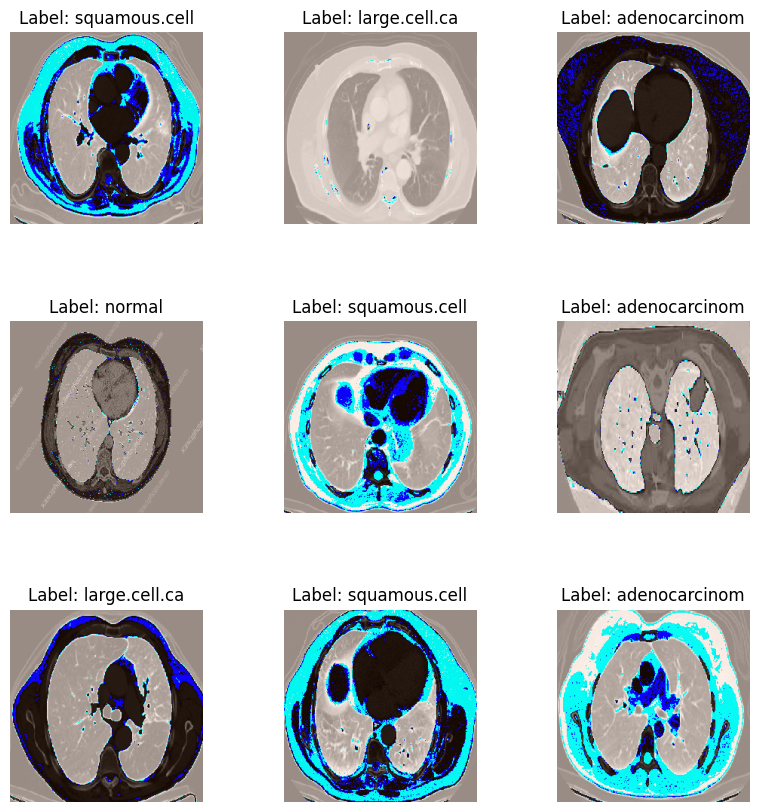

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data from the training generator
images, labels = train_generator.next()

# Get the class labels from the generator
class_labels = list(train_generator.class_indices.keys())
for i in range(len(class_labels)):
  class_labels[i]=class_labels[i][:13]
# Define the number of subplots
num_subplots = min(BATCH_SIZE, 9)  # Adjust the number of subplots as needed

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

# Iterate through the subplots
for i in range(num_subplots):
    ax = axes.flatten()[i]

    # Display the image
    ax.imshow(images[i].astype('uint8'))
    ax.axis('off')

    # Display the label
    true_label = class_labels[np.argmax(labels[i])]
    ax.set_title(f"Label: {true_label}")

# Show the plot
plt.show()

#plot the class distribustion

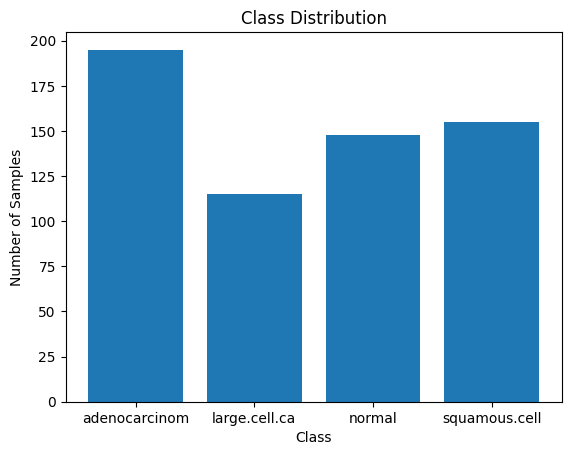

In [ ]:
import matplotlib.pyplot as plt

# Get the class labels and their counts from the training generator
class_labels = list(train_generator.class_indices.keys())
for i in range(len(class_labels)):
  class_labels[i]=class_labels[i][:13]
class_counts = train_generator.classes

# Plotting the bar plot
plt.bar(class_labels, [np.sum(class_counts == i) for i in range(len(class_labels))])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

# Show the plot
plt.show()


#start with deep learning models

#first resnet50

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


#build the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense

# Create a Sequential model
model = Sequential()

# Add the pre-trained ResNet model (assuming `res_model` is your ResNet model)
model.add(res_model)

# Add a Dropout layer to reduce overfitting (dropout rate of 0.4)
model.add(Dropout(0.4))

# Flatten the output from the ResNet model
model.add(Flatten())

# Apply Batch Normalization for better convergence and generalization
model.add(BatchNormalization())

# Add another Dropout layer after Batch Normalization
model.add(Dropout(0.4))

# Add a Dense layer with the number of classes and softmax activation for classification
model.add(Dense(N_CLASSES, activation='softmax'))

# Display a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

# Define a custom learning rate schedule

In [ ]:
def custom_learning_rate(epoch):
    initial_learning_rate = 0.00001
    decay_rate = 1e-5
    new_learning_rate = initial_learning_rate / (1.0 + decay_rate * epoch)
    return new_learning_rate

# Create a learning rate callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(custom_learning_rate)

# Create the Adam optimizer without specifying the learning rate
optimizer = tf.keras.optimizers.Adam()

# Compile the model with the optimizer and loss
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


#create checkpoint

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

#start training

In [ ]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping,lr_schedule])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.8790 - acc: 0.6884
Epoch 1: val_loss improved from inf to 215.88040, saving model to ./chest_CT_SCAN-ResNet50.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 34s 458ms/step - loss: 0.8790 - acc: 0.6884 - val_loss: 215.8804 - val_acc: 0.1806
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.2088 - acc: 0.9250
Epoch 2: val_loss did not improve from 215.88040
20/20 [==============================] - 5s 235ms/step - loss: 0.2088 - acc: 0.9250 - val_loss: 227.7864 - val_acc: 0.1806
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.1785 - acc: 0.9445
Epoch 3: val_loss improved from 215.88040 to 79.84822, saving model to ./chest_CT_SCAN-ResNet50.hdf5
20/20 [==============================] - 6s 317ms/step - loss: 0.1785 - acc: 0.9445 - val_loss: 79.8482 - val_acc: 0.1944
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.1109 - acc: 0.9657
Epoch 4: val_loss improved from 79.84822 to 70.63810, saving model to ./chest_CT_SCAN-ResNet50.hdf5
20/20 [==============================] - 6s 275ms/step - loss: 0.1109 - acc: 0.9657 - val_loss: 70.6381 - val_a

#plot the results

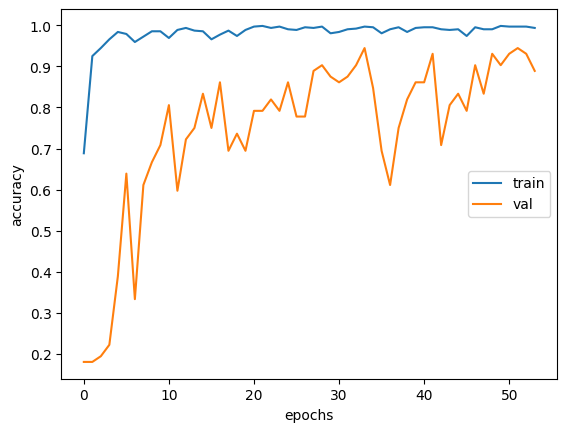

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model.save("res.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#DensNet201

#load data with different input shape

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#build the model

In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
# Create a Sequential model
model = Sequential()

# Add a Dense model (assuming `dense_model` is your Dense model)
model.add(dense_model)

# Add a Dropout layer to reduce overfitting (dropout rate of 0.5)
model.add(Dropout(0.5))

# Flatten the output from the Dense model
model.add(Flatten())

# Apply Batch Normalization for better convergence and generalization
model.add(BatchNormalization())

# Add a Dense layer with the number of classes and softmax activation for classification
model.add(Dense(N_CLASSES, activation='softmax'))

# Display a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4)                 7684      
                                                                 
Total params: 18337348 (69.95 MB)
Trainable params: 6990084 (26.67 MB)
Non-trainable params: 11347264 (43.29 MB)
_________

# Define a custom learning rate schedule


In [ ]:
def custom_learning_rate(epoch):
    initial_learning_rate = 0.00001
    decay = 1e-6
    new_learning_rate = initial_learning_rate / (1.0 + decay * epoch)
    return new_learning_rate

# Create the Adam optimizer without specifying the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate(10))  # Initialize with the initial learning rate

# Compile the model with the optimizer and loss
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


#create checkpoint

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 1.4501 - acc: 0.3475
Epoch 1: val_loss improved from inf to 1.22227, saving model to ./chest_CT_SCAN-DenseNet201.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 102s 1s/step - loss: 1.4501 - acc: 0.3475 - val_loss: 1.2223 - val_acc: 0.3472
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 1.2470 - acc: 0.4372
Epoch 2: val_loss improved from 1.22227 to 1.11186, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 17s 837ms/step - loss: 1.2470 - acc: 0.4372 - val_loss: 1.1119 - val_acc: 0.4167
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 1.0455 - acc: 0.5481
Epoch 3: val_loss improved from 1.11186 to 1.02696, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 16s 804ms/step - loss: 1.0455 - acc: 0.5481 - val_loss: 1.0270 - val_acc: 0.5139
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.9162 - acc: 0.6264
Epoch 4: val_loss improved from 1.02696 to 0.95426, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
20/20 [==============================] - 17s 866ms/step - loss:

#plot the results

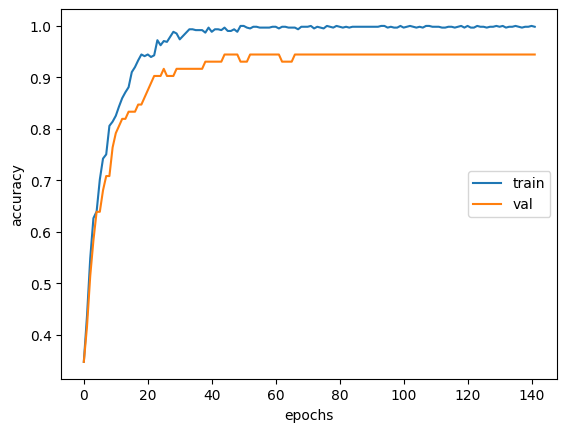

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model.save("dense.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#EfficientNetB4

#build the model

In [ ]:
efficient_model = EfficientNetB4(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in efficient_model.layers:
    if 'block7'not in layer.name and'top' not in layer.name:
        layer.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
# Create a Sequential model
model = Sequential()

# Add an EfficientNet model (assuming `efficient_model` is your EfficientNet model)
model.add(efficient_model)

# Add a Dropout layer to reduce overfitting (dropout rate of 0.6)
model.add(Dropout(0.6))

# Flatten the output from the EfficientNet model
model.add(Flatten())

# Apply Batch Normalization for better convergence and generalization
model.add(BatchNormalization())

# Add another Dropout layer after Batch Normalization
model.add(Dropout(0.6))

# Add a Dense layer with the number of classes and softmax activation for classification
model.add(Dense(N_CLASSES, activation='softmax'))

# Display a summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1792)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1792)              7168      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                


# Define a custom learning rate schedule

In [ ]:
def custom_learning_rate(epoch):
    initial_learning_rate = 0.00001
    decay = 1e-6
    new_learning_rate = initial_learning_rate / (1.0 + decay * epoch)
    return new_learning_rate

# Create a custom optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate(0))  # Initialize with the initial learning rate

# Compile the model with the custom optimizer and loss
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['acc'])


#create checkpoint

In [ ]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

#start training

In [ ]:
history_efficient = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 2.4621 - acc: 0.2806
Epoch 1: val_loss improved from inf to 1.37430, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 52s 1s/step - loss: 2.4621 - acc: 0.2806 - val_loss: 1.3743 - val_acc: 0.3333
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 2.3339 - acc: 0.2806
Epoch 2: val_loss improved from 1.37430 to 1.34186, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 17s 843ms/step - loss: 2.3339 - acc: 0.2806 - val_loss: 1.3419 - val_acc: 0.3194
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 2.1406 - acc: 0.3197
Epoch 3: val_loss improved from 1.34186 to 1.30827, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
20/20 [==============================] - 17s 831ms/step - loss: 2.1406 - acc: 0.3197 - val_loss: 1.3083 - val_acc: 0.3194
Epoch 4/200
20/20 [==============================] - ETA: 0s - lo

#plot the results

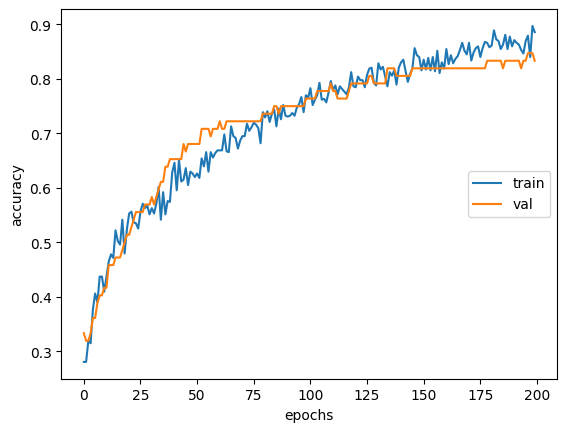

In [ ]:
plt.plot(history_efficient.history['acc'], label = 'train',)
plt.plot(history_efficient.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model.save("EfficientNetB4.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#VGG16

# load data with different input shape

In [ ]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

In [ ]:
train_data = trainGenertor.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    valid_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#build the model

In [ ]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.src.metrics.confusion_metrics import activations
# Create a Sequential model
model = Sequential()

# Add a pre-trained VGG16 model (assuming `VGG16_model` is your VGG16 model)
model.add(VGG16_model)

# Apply Batch Normalization for better convergence and generalization
model.add(BatchNormalization())

# Add a MaxPooling2D layer with a pool size of (2, 2)
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the VGG16 model
model.add(Flatten())

# Add a Dense layer with 1024 neurons and ReLU activation function
model.add(Dense(1024, activation='relu'))

# Introduce a Dropout layer with a dropout rate of 0.3 to reduce overfitting
model.add(Dropout(0.3))

# Add another Dense layer with 512 neurons and ReLU activation function
model.add(Dense(512, activation='relu'))

# Introduce another Dropout layer with a dropout rate of 0.3
model.add(Dropout(0.3))

# Add another Dense layer with 256 neurons and ReLU activation function
model.add(Dense(256, activation='relu'))

# Add a Dense layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))

# Add the output layer with the number of classes and softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Display a summary of the model architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_3 (Dropout)         (None, 1024)             

#compile the model

In [ ]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

#start training

In [ ]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 19s 361ms/step - loss: 1.5469 - accuracy: 0.4013 - val_loss: 2.3497 - val_accuracy: 0.4444
Epoch 2/100
39/39 [==============================] - 11s 276ms/step - loss: 1.2370 - accuracy: 0.4698 - val_loss: 1.0836 - val_accuracy: 0.4028
Epoch 3/100
39/39 [==============================] - 11s 279ms/step - loss: 1.0273 - accuracy: 0.5367 - val_loss: 0.9401 - val_accuracy: 0.5278
Epoch 4/100
39/39 [==============================] - 12s 296ms/step - loss: 0.9277 - accuracy: 0.5856 - val_loss: 1.0664 - val_accuracy: 0.4722
Epoch 5/100
39/39 [==============================] - 12s 309ms/step - loss: 0.9070 - accuracy: 0.5791 - val_loss: 0.7852 - val_accuracy: 0.5833
Epoch 6/100
39/39 [==============================] - 11s 292ms/step - loss: 0.9382 - accuracy: 0.5873 - val_loss: 1.0246 - val_accuracy: 0.5278
Epoch 7/100
39/39 [==============================] - 11s 292ms/step - loss: 0.8635 - accuracy: 0.6069 - val_loss: 0.9899 - val_accuracy:

#plot the results

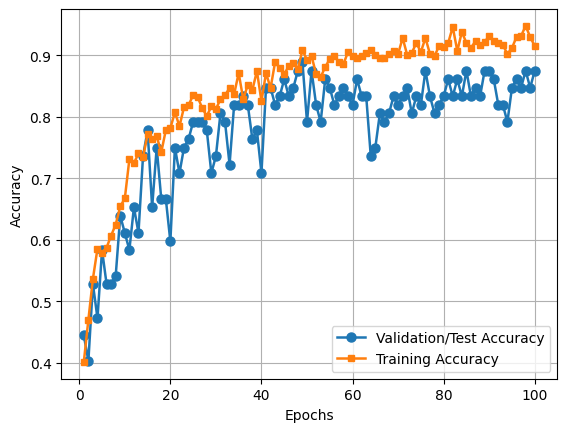

In [ ]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#plot the loss function

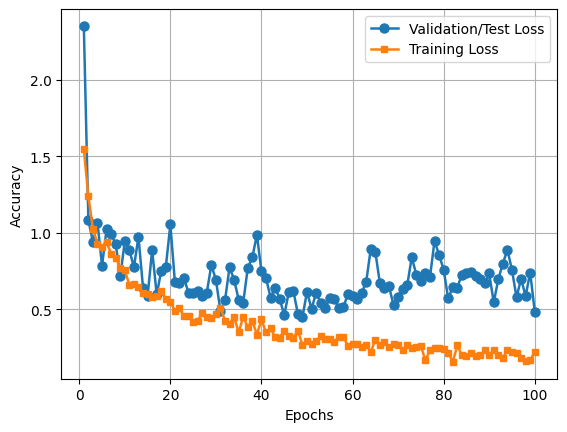

In [ ]:
res = results.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

line1 = plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, train_loss, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model.save("vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#models Evalution

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

#Res50 Evaluation

In [ ]:
# Load the pre-trained model
Res50_model = load_model('/content/res.h5')
#evaluate on test data
res_test_accuracy = Res50_model.evaluate(test_generator)


3/3 [==============================] - 4s 129ms/step - loss: 0.4400 - acc: 0.8889


#Dense Evaluation

In [ ]:
# Load the pre-trained model
Dense_model = load_model('/content/dense.h5')

dense_test_accuracy = Dense_model.evaluate(test_generator)


3/3 [==============================] - 5s 339ms/step - loss: 0.2143 - acc: 0.9444


#EfficientNetB4 Evaluation

In [ ]:
# Load the pre-trained model
EfficientNetB4_model = load_model('/content/EfficientNetB4.h5')

EfficientNetB4_test_accuracy = EfficientNetB4_model.evaluate(test_generator)


10/10 [==============================] - 11s 604ms/step - loss: 0.5124 - acc: 0.8444


#VGG16 Evaluation

In [ ]:
# Load the pre-trained model
VGG16_model = load_model('/content/vgg16 (1).h5')

vgg_test_accuracy = VGG16_model.evaluate(test_data)


5/5 [==============================] - 1s 90ms/step - loss: 0.4860 - accuracy: 0.8750


#print the results for all models

In [ ]:
import pandas as pd
import tensorflow as tf

models_name=['Res50','VGG16','Efficient','Dense']

test_accuracies = [res_test_accuracy,vgg_test_accuracy,EfficientNetB4_test_accuracy,dense_test_accuracy]
final_accuracies=[]
for test_accuracy in test_accuracies:
    final_accuracies.append(test_accuracy[1])



df = pd.DataFrame({'Model':models_name,'Test Accuracy': final_accuracies})
df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

df.reset_index(drop=True, inplace=True)
df.head()


,Model,Test Accuracy
0,Dense,0.944444
1,Res50,0.888889
2,VGG16,0.875000
3,Efficient,0.844444
